In [8]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt, PIDController, Kvaerno3
import optax  
import pickle as pkl
from reaction_nets import rxn_net
from functools import partial
import scipy.optimize
import os
import equinox as eqx
from jax import make_jaxpr
import initialize_nets

In [9]:
jax.config.update("jax_enable_x64", True)

This file generates the training data used to optimize the triangle topology networks. It saves the training data and inputs to the model in a dictionary which is saved / compressed and later read in to the optimizing file. 

# Single monotonic curves

In [3]:
n_samples = 1000
species_list=['A', 'B', 'C']
solver=Tsit5()
stepsize_controller=PIDController(0.005, 0.01)
t_points=jnp.linspace(0.0, 10.0, 200)
dt0=0.001
max_steps=10000

For topology B, generating training data set, plotting to ensure data set looks correct, and saving.  

In [4]:
#generate network
network_type='triangle_b'
rxn, initial_params, initial_conditions, true_params=initialize_nets.initialize_rxn_net(network_type)

checking that initial and true parameters are correct.

In [5]:
print(initial_params.shape)

(12,)


In [6]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=initial_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

1.2840254166877414 1.2840254166877414 1.2840254166877414 0.7788007830714049 0.7788007830714049 0.7788007830714049


In [8]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=true_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

1.0 1.0 0.05000000000000001 10.000000000000002 0.10000000000000002 4.0


generating training data and plotting for confirmation.

In [7]:
#generate training data 
training_data_type='simple_monotonic'
train_features, train_labels, val_features, val_labels = initialize_nets.gen_training_data(rxn, training_data_type, n_samples, true_params, initial_conditions, solver, stepsize_controller, t_points, dt0, max_steps)

Features shape: (1000,)
Labels shape: (1000, 3)


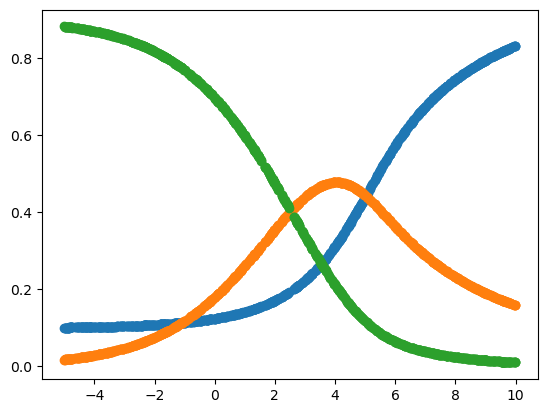

In [9]:
for species, profile in zip(species_list, train_labels.T):
    plt.scatter(train_features, profile, label=f'{species}')

storing info in dict which is compressed and saved.

In [10]:
init_data_b={'network_type': network_type, 'initial_params':initial_params, 'initial_conditions':initial_conditions, 'true_params': true_params, 'training_data_type':training_data_type, 'train_features': train_features, 'train_labels': train_labels, 'val_features':val_features, 'val_labels': val_labels, 'solver':solver, 'stepsize_controller':stepsize_controller, 't_points':t_points, 'dt0':dt0, 'max_steps':max_steps}

In [13]:
init_data_file=f'data/init_data/{network_type}'

f=open(init_data_file, 'wb')
pkl.dump(init_data_b, f)
f.close()

reading back in to test.

In [15]:
f=open(init_data_file, 'rb')
init_data_b_test=pkl.load(f)
f.close()

In [18]:
print(init_data_b_test['network_type'])
print(init_data_b['network_type'])
print('\n')
print(init_data_b_test['initial_params'])
print(init_data_b['initial_params'])
print('\n')
print(init_data_b_test['initial_conditions'])
print(init_data_b['initial_conditions'])
print('\n')
print(init_data_b_test['true_params'])
print(init_data_b['true_params'])

triangle_b
triangle_b


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[-1.2039728  -0.91629073 -1.2039728 ]
[-1.2039728  -0.91629073 -1.2039728 ]


[-0.         -0.         -0.         -0.         -0.         -2.30258509
 -0.         -0.          2.30258509  2.99573227 -0.         -1.38629436]
[-0.         -0.         -0.         -0.         -0.         -2.30258509
 -0.         -0.          2.30258509  2.99573227 -0.         -1.38629436]


Doing the same for the other two networks with the triangle topology. 

In [28]:
network_type='triangle_a'
rxn, initial_params, initial_conditions, true_params=initialize_nets.initialize_rxn_net(network_type)

In [20]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=initial_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

1.2840254166877414 1.2840254166877414 1.2840254166877414 0.7788007830714049 0.7788007830714049 0.7788007830714049


In [21]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=true_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

1.0 1.0 0.05000000000000001 10.000000000000002 0.10000000000000002 4.0


In [22]:
training_data_type='simple_monotonic'
train_features, train_labels, val_features, val_labels = initialize_nets.gen_training_data(rxn, training_data_type, n_samples, true_params, initial_conditions, solver, stepsize_controller, t_points, dt0, max_steps)

Features shape: (1000,)
Labels shape: (1000, 3)


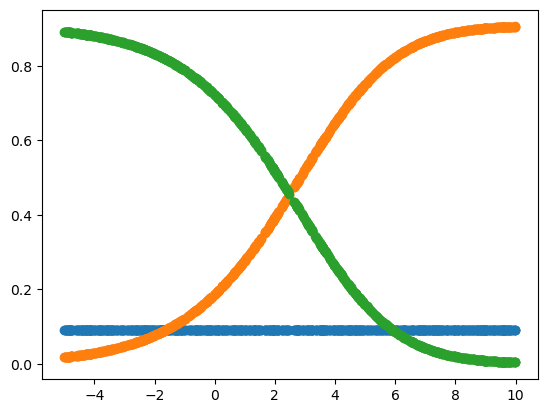

In [23]:
for species, profile in zip(species_list, train_labels.T):
    plt.scatter(train_features, profile, label=f'{species}')

In [29]:
init_data_a={'network_type': network_type, 'initial_params':initial_params, 'initial_conditions':initial_conditions, 'true_params': true_params, 'training_data_type':training_data_type, 'train_features': train_features, 'train_labels': train_labels, 'val_features':val_features, 'val_labels': val_labels, 'solver':solver, 'stepsize_controller':stepsize_controller, 't_points':t_points, 'dt0':dt0, 'max_steps':max_steps}

In [30]:
init_data_file=f'data/init_data/{network_type}'
f=open(init_data_file, 'wb')
pkl.dump(init_data_a, f)
f.close()

In [31]:
f=open(init_data_file, 'rb')
init_data_a_test=pkl.load(f)
f.close()

In [ ]:
print(init_data_a_test['network_type'])
print(init_data_a['network_type'])
print('\n')
print(init_data_a_test['initial_params'])
print(init_data_a['initial_params'])
print('\n')
print(init_data_a_test['initial_conditions'])
print(init_data_a['initial_conditions'])
print('\n')
print(init_data_a_test['true_params'])
print(init_data_a['true_params'])
print('\n')
print(init_data_a_test['train_labels'].T)
print(init_data_a['train_labels'].T)

triangle_a
triangle_a


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[-1.2039728  -0.91629073 -1.2039728 ]
[-1.2039728  -0.91629073 -1.2039728 ]


[-0.         -0.         -0.         -0.         -0.         -2.30258509
 -0.         -0.          2.30258509  2.99573227 -0.         -1.38629436]
[-0.         -0.         -0.         -0.         -0.         -2.30258509
 -0.         -0.          2.30258509  2.99573227 -0.         -1.38629436]


[[0.09009009 0.07660163 0.83330828]
 [0.09009009 0.86487694 0.04503297]
 [0.09009009 0.05803826 0.85187165]
 ...
 [0.09009009 0.10595425 0.80395566]
 [0.09009009 0.02439701 0.8855129 ]
 [0.09009009 0.57492776 0.33498215]]
[[0.09009009 0.07660163 0.83330828]
 [0.09009009 0.86487694 0.04503297]
 [0.09009009 0.05803826 0.85187165]
 ...
 [0.09009009 0.10595425 0.80395566]
 [0.09009009 0.02439701 0.8855129 ]
 [0.09009009 0.57492776 0.33498215]]


In [35]:
network_type='triangle_c'
rxn, initial_params, initial_conditions, true_params=initialize_nets.initialize_rxn_net(network_type)

Features shape: (1000,)
Labels shape: (1000, 3)


In [ ]:
training_data_type='simple_monotonic'
train_features, train_labels, val_features, val_labels = initialize_nets.gen_training_data(rxn, training_data_type, n_samples, true_params, initial_conditions, solver, stepsize_controller, t_points, dt0, max_steps)

In [36]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=initial_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

1.2840254166877414 1.2840254166877414 1.2840254166877414 0.7788007830714049 0.7788007830714049 0.7788007830714049


In [37]:
E_A, E_B, E_C, B_AB, F_AB, B_BA, B_AC, F_AC, B_CA, B_BC, F_BC, B_CB=true_params
F_BC_in=0
F_CB_in=-F_BC_in
F_AB_in, F_BA_in, F_AC_in,F_CA_in = 0, 0, 0, 0

F_BA=-F_AB
F_CA=-F_AC
F_CB=-F_BC

#jax.debug.print('params:{params}', params=params)
W_AB=jnp.exp(E_A-B_AB+0.5*F_AB + 0.5*F_AB_in)
W_BA=jnp.exp(E_B-B_BA+0.5*F_BA + 0.5*F_BA_in)
W_AC=jnp.exp(E_A-B_AC+0.5*F_AC + 0.5*F_AC_in)
W_CA=jnp.exp(E_C-B_CA+0.5*F_CA + 0.5*F_CA_in)
W_BC=jnp.exp(E_B-B_BC+0.5*F_BC + 0.5*F_BC_in)
W_CB=jnp.exp(E_C-B_CB+0.5*F_CB + 0.5*F_CB_in)

print(W_AB, W_AC, W_BC, W_BA, W_CA, W_CB)

1.0 1.0 0.05000000000000001 10.000000000000002 0.10000000000000002 4.0


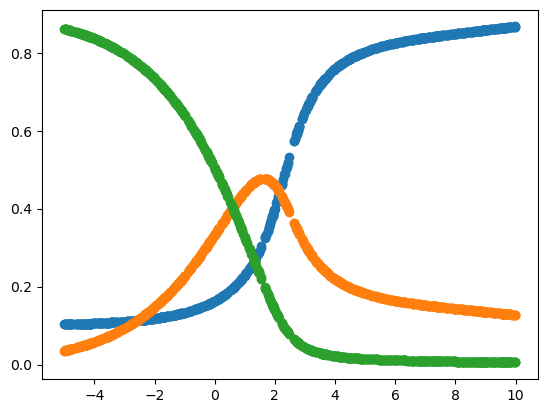

In [38]:
for species, profile in zip(species_list, train_labels.T):
    plt.scatter(train_features, profile, label=f'{species}')

In [39]:
init_data_c={'network_type': network_type, 'initial_params':initial_params, 'initial_conditions':initial_conditions, 'true_params': true_params, 'training_data_type':training_data_type, 'train_features': train_features, 'train_labels': train_labels, 'val_features':val_features, 'val_labels': val_labels, 'solver':solver, 'stepsize_controller':stepsize_controller, 't_points':t_points, 'dt0':dt0, 'max_steps':max_steps} 

In [40]:
init_data_file=f'data/init_data/{network_type}'
f=open(init_data_file, 'wb')
pkl.dump(init_data_c, f)
f.close()

In [41]:
f=open(init_data_file, 'rb')
init_data_c_test=pkl.load(f)
f.close()

In [42]:
print(init_data_c_test['network_type'])
print(init_data_c['network_type'])
print('\n')
print(init_data_c_test['initial_params'])
print(init_data_c['initial_params'])
print('\n')
print(init_data_c_test['initial_conditions'])
print(init_data_c['initial_conditions'])
print('\n')
print(init_data_c_test['true_params'])
print(init_data_c['true_params'])
print('\n')
print(init_data_c_test['train_labels'].T)
print(init_data_c['train_labels'].T)

triangle_c
triangle_c


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[-1.2039728  -0.91629073 -1.2039728 ]
[-1.2039728  -0.91629073 -1.2039728 ]


[-0.         -0.         -0.         -0.         -0.         -2.30258509
 -0.         -0.          2.30258509  2.99573227 -0.         -1.38629436]
[-0.         -0.         -0.         -0.         -0.         -2.30258509
 -0.         -0.          2.30258509  2.99573227 -0.         -1.38629436]


[[0.11833176 0.8377039  0.11300342 ... 0.1277726  0.10440763 0.70779506]
 [0.14658657 0.15292383 0.11206763 ... 0.19958701 0.04780796 0.26100077]
 [0.73508167 0.00937227 0.77492894 ... 0.67264038 0.84778441 0.03120417]]
[[0.11833176 0.8377039  0.11300342 ... 0.1277726  0.10440763 0.70779506]
 [0.14658657 0.15292383 0.11206763 ... 0.19958701 0.04780796 0.26100077]
 [0.73508167 0.00937227 0.77492894 ... 0.67264038 0.84778441 0.03120417]]


# Double monotonic

In [10]:
n_samples = 1000
species_list=['A', 'B', 'C']
training_data_type='double_monotonic'
network_type='triangle_b'
solver=Tsit5()
stepsize_controller=PIDController(0.005, 0.01)
t_points=jnp.linspace(0.0, 10.0, 200)
dt0=0.001
max_steps=10000

In [11]:
rxn, initial_params, initial_conditions, true_params=initialize_nets.initialize_rxn_net(network_type)

In [12]:
train_features, train_labels, val_features, val_labels = initialize_nets.gen_training_data(rxn, training_data_type, n_samples, true_params)

Features shape: (1000,)
Labels shape: (1000, 3)


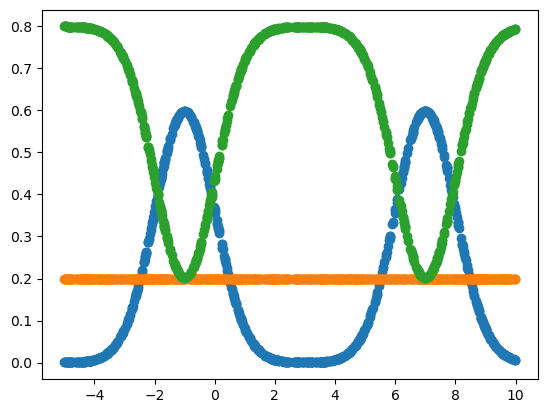

In [13]:
for species, profile in zip(species_list, train_labels.T):
    plt.scatter(train_features, profile, label=f'{species}')

In [14]:
init_data_b_double={'network_type': network_type, 'initial_params':initial_params, 'initial_conditions':initial_conditions, 'true_params': true_params, 'training_data_type':training_data_type, 'train_features': train_features, 'train_labels': train_labels, 'val_features':val_features, 'val_labels': val_labels, 'solver':solver, 'stepsize_controller':stepsize_controller, 't_points':t_points, 'dt0':dt0, 'max_steps':max_steps}

In [15]:
init_data_file=f'data/init_data/triangle_b_double_monotonic'

f=open(init_data_file, 'wb')
pkl.dump(init_data_b_double, f)
f.close()

In [16]:
f=open(init_data_file, 'rb')
init_data_b_double_test=pkl.load(f)
f.close()


print(init_data_b_double_test['network_type'])
print(init_data_b_double['initial_params'])
print(init_data_b_double['initial_conditions'])
print(init_data_b_double['training_data_type'])

triangle_b
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[-1.2039728  -0.91629073 -1.2039728 ]
double_monotonic
